In [1]:
from gym_compete_rllib.gym_compete_to_rllib import create_env, MultiAgentToSingleAgent, model_to_callable
from gym_compete_rllib.load_gym_compete_policy import get_policy_value_nets
from gym_compete_rllib.test_single_agent_env import episode
import gym
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
import ray
from time import time
import pandas as pd
from tqdm import tqdm

In [2]:
ray.shutdown()
info = ray.init(ignore_reinit_error=True, log_to_driver=False)
num_workers = 10
env_name = 'multicomp/YouShallNotPassHumans-v0'

2020-08-19 17:41:12,913	INFO resource_spec.py:204 -- Starting Ray with 3.86 GiB memory available for workers and up to 1.95 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-08-19 17:41:13,138	WARNING services.py:923 -- Redis failed to start, retrying now.
2020-08-19 17:41:13,356	INFO services.py:1163 -- View the Ray dashboard at localhost:8267


In [3]:
env = create_env(config=dict(with_video=False, env_name=env_name))
policy_model_1 = model_to_callable(get_policy_value_nets(env_name, 1)['policy'])
env = MultiAgentToSingleAgent(env_config=dict(env=env, policies={'player_2': policy_model_1}))

Creating agent humanoid_blocker
Reading agent XML from: /home/sergei/git/chai/multiagent-competition/gym_compete/new_envs/assets/humanoid_body.xml
Creating agent humanoid
Reading agent XML from: /home/sergei/git/chai/multiagent-competition/gym_compete/new_envs/assets/humanoid_body.xml
Scene XML path: /home/sergei/git/chai/multiagent-competition/gym_compete/new_envs/assets/world_body.humanoid_body.humanoid_body.xml
Created Scene with agents
Creating agent humanoid_blocker
Reading agent XML from: /home/sergei/git/chai/multiagent-competition/gym_compete/new_envs/assets/humanoid_body.xml
Creating agent humanoid
Reading agent XML from: /home/sergei/git/chai/multiagent-competition/gym_compete/new_envs/assets/humanoid_body.xml
Scene XML path: /home/sergei/git/chai/multiagent-competition/gym_compete/new_envs/assets/world_body.humanoid_body.humanoid_body.xml
Created Scene with agents


In [4]:
@ray.remote
class Evaluator(object):
    """Evaluates a policy in the 1-agent env."""
    def __init__(self, env_name):
        env = create_env(config=dict(with_video=False, env_name=env_name))
        policy_model_1 = model_to_callable(get_policy_value_nets(env_name, 1)['policy'])
        self.env = MultiAgentToSingleAgent(env_config=dict(env=env, policies={'player_2': policy_model_1}))
    def episode(self, policy):
        return episode(self.env, policy)
    
def rewards(pool, ps):
    """Rewards for an array of policies."""
    return [v for v in pool.map(lambda a, v: a.episode.remote(v), ps)]

def compute_rewards(pool, p, total_episodes=100):
    """Compute rewards using a pool."""
    return [v for v in pool.map_unordered(lambda a, v: a.episode.remote(v), [p] * total_episodes)]

In [5]:
actors = [Evaluator.remote(env_name=env_name) for _ in range(num_workers)]
pool = ray.util.ActorPool(actors)

# Constant policy output

In [6]:
out_size = 17
n_population = 10
n_children = 2
init_std = 2
noise_std = 0.1
eval_episodes = 20

p = np.random.randn(n_population, out_size) * init_std

def mutate(p):
    p1 = np.repeat(p, n_children, axis=0)
    return p1 + np.random.randn(*p1.shape) * noise_std

def rewards(pool, ps):
    """Rewards for an array of policies."""
    with tqdm(total=len(ps)) as pbar:
        def f(a, v):
            res = a.episode.remote(v)
            pbar.update(1)
            return res
        
        return [v for v in pool.map(f, ps)]

In [11]:
to_eval = mutate(p)

policies = [ray.put(lambda _, v=v: v) for v in to_eval]
policies = [p for p in policies for _ in range(eval_episodes)]
rs = rewards(pool, policies)
rs = np.array(rs).reshape((len(to_eval), eval_episodes))
rs = np.mean(rs, axis=1)

100%|██████████| 400/400 [01:15<00:00,  5.27it/s]


In [10]:
rs

array([ -6.,  -6.,  -8.,  -9., -10.,  -9., -10., -10., -10., -10.,  -9.,
       -10.,  -8., -10., -10.,  -9., -10., -10., -10.,  -9.])

In [12]:
rs

array([ -9.,  -8., -10., -10.,  -8.,  -9.,  -9.,  -9., -10.,  -9., -10.,
        -9., -10.,  -9.,  -8.,  -9.,  -8.,  -6.,  -9.,  -9.])

(array([ 5.,  0., 10.,  0.,  0.,  4.,  0.,  0.,  0.,  1.]),
 array([-10. ,  -9.6,  -9.2,  -8.8,  -8.4,  -8. ,  -7.6,  -7.2,  -6.8,
         -6.4,  -6. ]),
 <a list of 10 Patch objects>)

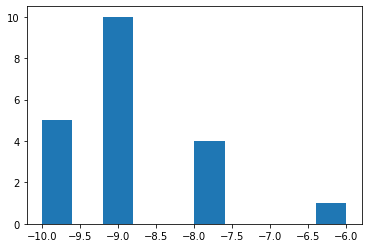

In [13]:
plt.hist(rs)